## Solving the Burgers Equation using a Physics-Informed Neural Network

This notebook aims to reproduce the work by authors in the paper at https://onlinelibrary.wiley.com/doi/full/10.1002/gamm.202100006

Burger's PDE $ u_t + uu_x - (0.01/\pi) u_{xx} = 0 $<br>
Valid in Domain: $ x \in [-1,1] $ and $ t \in (0,1] $<br>
Initial Condition: $ u(0,x) = - \sin(\pi x) $<br>
Boundary Condition: $ u(t,-1) = u(t,1) = 0 $<br>

In [ ]:
import tensorflow as tf
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float
pi = tf.constant(m.pi, dtype=DTYPE)

def u_init(x): # calculates u value at initial data points
  return -tf.sin(pi * x)

def u_bound(t, x): # calculates u value at boundary data points
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)

def f_val(u, u_t, u_x, u_xx): # calculates f value given u and its derivatives
  return u_t + u * u_x - (0.01/pi) * u_xx

In [ ]:
# Training Data

Ni, Nb, Nc = 50, 50, 10000 # no of initial, boundary and collocation points

tmin, tmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin, xmax = -tf.constant(1.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

ti = tf.ones((Ni,1))*tmin # tmin repeated Ni times
xi = tf.random.uniform((Ni,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init = tf.concat([ti, xi], axis=1) # Initial Data Points
ui = u_init(xi) # Evaluate Initial Condition

tb = tf.random.uniform((Nb,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
bin = tf.keras.backend.random_bernoulli((Nb,1), 0.5, dtype=DTYPE) # randomly generate 0 or 1 Nb times
xb = xmin + (xmax - xmin) * bin # convert 0s and 1s to xmin and xmax
bound = tf.concat([tb, xb], axis=1) # Boundary Data Points
ub = u_bound(tb, xb) # Evaluate Boundary Condition

tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll = tf.concat([tc, xc], axis=1) # Collocation Data Points

In [ ]:
# Validation Data (in 1:5 ratio with training data)

Ni2, Nb2, Nc2 = 10, 10, 2000 # no of initial, boundary and collocation points

tmin2, tmax2 = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin2, xmax2 = -tf.constant(1.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

ti2 = tf.ones((Ni2,1))*tmin2 # tmin repeated Ni times
xi2 = tf.random.uniform((Ni2,1), xmin2, xmax2, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init2 = tf.concat([ti2, xi2], axis=1) # Initial Data Points
ui2 = u_init(xi2) # Evaluate Initial Condition

tb2 = tf.random.uniform((Nb2,1), tmin2, tmax2, dtype=DTYPE) # uniformly sample bwn tmin and tmax
bin2 = tf.keras.backend.random_bernoulli((Nb2,1), 0.5, dtype=DTYPE) # randomly generate 0 or 1 Nb times
xb2 = xmin2 + (xmax2 - xmin2) * bin2 # convert 0s and 1s to xmin and xmax
bound2 = tf.concat([tb2, xb2], axis=1) # Boundary Data Points
ub2 = u_bound(tb2, xb2) # Evaluate Boundary Condition

tc2 = tf.random.uniform((Nc2,1), tmin2, tmax2, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc2 = tf.random.uniform((Nc2,1), xmin2, xmax2, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll2 = tf.concat([tc2, xc2], axis=1) # Collocation Data Points

In [ ]:
# model with weight regularizer and dropout
def u_model(n_hidden = 8, n_neurons = 20):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - tf.stack([tmin, xmin]))/(tf.stack([tmax, xmax]) - tf.stack([tmin, xmin])) - 1.0)
  model.add(scaling_layer)
  for i in range(n_hidden): # n_hidden layers each with n_neurons and tanh activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('tanh'), kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for u
  return model

In [ ]:
def u_model(n_hidden = 8, n_neurons = 20):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - tf.stack([tmin, xmin]))/(tf.stack([tmax, xmax]) - tf.stack([tmin, xmin])) - 1.0)
  model.add(scaling_layer)
  for i in range(n_hidden): # n_hidden layers each with n_neurons and tanh activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('tanh'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for u
  return model

In [ ]:
def get_f(model, cps): # calculate f given model and collocation data points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = model(tf.concat([t, x], axis=1)) # u as a function of t and x
    u_x = tape.gradient(u, x) # defined within context to compute 2nd derivative
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)
  del tape
  return f_val(u, u_t, u_x, u_xx)

In [ ]:
def loss_fxn(model, init, ui, bound, ub, coll): # compute Loss given model and data
  pui = model(init) # Model prediction on initial data
  Li = tf.reduce_mean(tf.square(ui - pui)) # MSE for initial data
  pub = model(bound) # Model prediction on boundary data
  Lb = tf.reduce_mean(tf.square(ub - pub)) # MSE for boundary data
  f = get_f(model, coll) # calculate f given model and collocation data
  Lc = tf.reduce_mean(tf.square(f)) # MSE for collocation data (true value of f is always 0)
  loss = Li + Lb + Lc
  return loss

In [ ]:
def L_and_grad_Lw(model, init, ui, bound, ub, coll): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(model.trainable_variables) # keep track of operations on model training parameters
    loss = loss_fxn(model, init, ui, bound, ub, coll) # loss as a function of model (& hence weights)
  g = tape.gradient(loss, model.trainable_variables)
  del tape
  return loss, g

In [ ]:
model = u_model() # initialise the NN model
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.Adam(learning_rate=lr) # Adam optimizer

In [ ]:
@tf.function
def train_step():
  # compute loss and its gradient wrt model parameters
  loss, gradw = L_and_grad_Lw(model, init, ui, bound, ub, coll)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gradw, model.trainable_variables))
  return loss

In [ ]:
@tf.function
def train_step_with_val():
  # compute loss and its gradient wrt model parameters
  loss, gradw = L_and_grad_Lw(model, init, ui, bound, ub, coll)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gradw, model.trainable_variables))
  val_loss = loss_fxn(model, init2, ui2, bound2, ub2, coll2)
  return loss, val_loss

Final Loss = 0.00087428
Computation Time = 403.7545545101166 seconds


Text(0, 0.5, 'Loss')

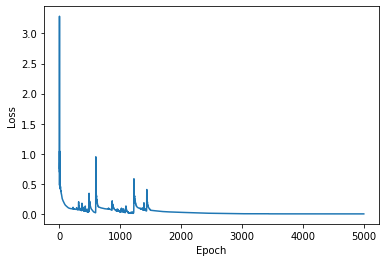

In [ ]:
# training of model with weight regularizer
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  loss = train_step()
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))
epochs = [i for i in range(1,N+1)]
import matplotlib.pyplot as plt
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Final Loss = 0.0009985216
Computation Time = 401.4154968261719 seconds


Text(0, 0.5, 'Loss')

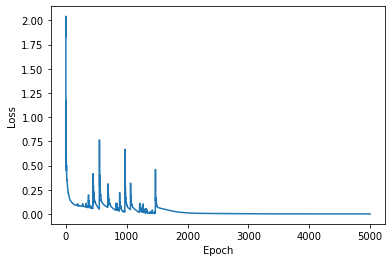

In [ ]:
# training of model with dropout
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  loss = train_step()
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))
epochs = [i for i in range(1,N+1)]
import matplotlib.pyplot as plt
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# looping over hyperparameters to find which yield least training loss
layers = [4,8,12,16,20]
neurons = [12,18,24,30,36]
for n_layers in layers:
  for n_neurons in neurons:
    model = u_model(n_layers,n_neurons)
    print('Model with '+str(n_layers)+' hidden layers each with '+str(n_neurons)+' neurons')
    N = 5000
    losses = []
    t0 = time()
    for i in range(1,N+1):
      loss = train_step()
      losses.append(loss.numpy())
    print('Final Loss = '+str(losses[-1]))
    print('Computation Time = {} seconds'.format(time()-t0))
    print()

Model with 4 hidden layers each with 12 neurons
Final Loss = 5.779401e-05
Computation Time = 423.9857106208801 seconds

Model with 4 hidden layers each with 18 neurons
Final Loss = 2.6679372e-05
Computation Time = 425.63666915893555 seconds

Model with 4 hidden layers each with 24 neurons
Final Loss = 1.740149e-05
Computation Time = 424.34257078170776 seconds

Model with 4 hidden layers each with 30 neurons
Final Loss = 1.2906242e-05
Computation Time = 427.4472577571869 seconds

Model with 4 hidden layers each with 36 neurons
Final Loss = 2.803453e-05
Computation Time = 426.0057511329651 seconds

Model with 8 hidden layers each with 12 neurons
Final Loss = 2.6648497e-05
Computation Time = 417.0809278488159 seconds

Model with 8 hidden layers each with 18 neurons
Final Loss = 7.541395e-06
Computation Time = 413.88415694236755 seconds

Model with 8 hidden layers each with 24 neurons
Final Loss = 1.0967552e-05
Computation Time = 421.4076762199402 seconds

Model with 8 hidden layers each w

In [ ]:
model = u_model(20,18) # best fit NN model
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.Adam(learning_rate=lr) # Adam optimizer

Final Training Loss = 0.00065747416 and Final Validation Loss = 0.0006892984
Computation Time = 1216.6347935199738 seconds


Text(0, 0.5, 'Loss')

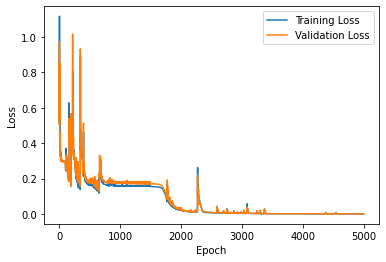

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses, val_losses = [], []
t0 = time()
for i in range(1,N+1):
  loss, val_loss = train_step_with_val()
  losses.append(loss.numpy())
  val_losses.append(val_loss.numpy())
print('Final Training Loss = '+str(losses[-1])+' and Final Validation Loss = '+str(val_losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))
epochs = [i for i in range(1,N+1)]
import matplotlib.pyplot as plt
plt.plot(epochs, losses)
plt.plot(epochs, val_losses)
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses, val_losses = [], []
t0 = time()
for i in range(1,N+1):
  loss, val_loss = train_step_with_val()
  losses.append(loss.numpy())
  val_losses.append(val_loss.numpy())
print('Final Training Loss = '+str(losses[-1])+' and Final Validation Loss = '+str(val_losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0)) # GPU

Final Training Loss = 0.00020259342 and Final Validation Loss = 0.00019588717
Computation Time = 61.57503271102905 seconds


Text(0, 0.5, 'Loss')

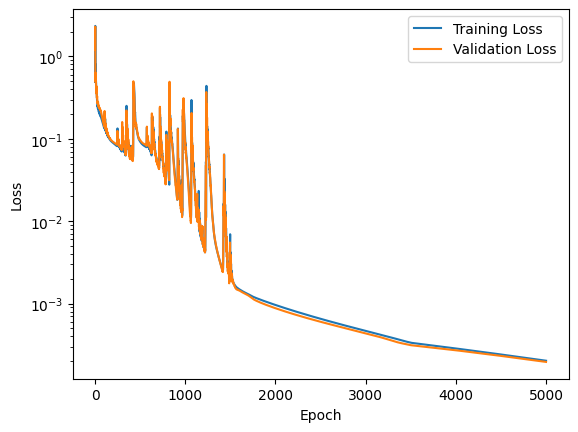

In [ ]:
epochs = [i for i in range(1,N+1)]
import matplotlib.pyplot as plt
plt.yscale('log')
plt.plot(epochs, losses)
plt.plot(epochs, val_losses)
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
N = 500
import numpy as np
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = model(input)
U = u_pred.numpy().reshape(N+1,N+1)

Text(0.5, 0.92, 'BE Solution by PINN')

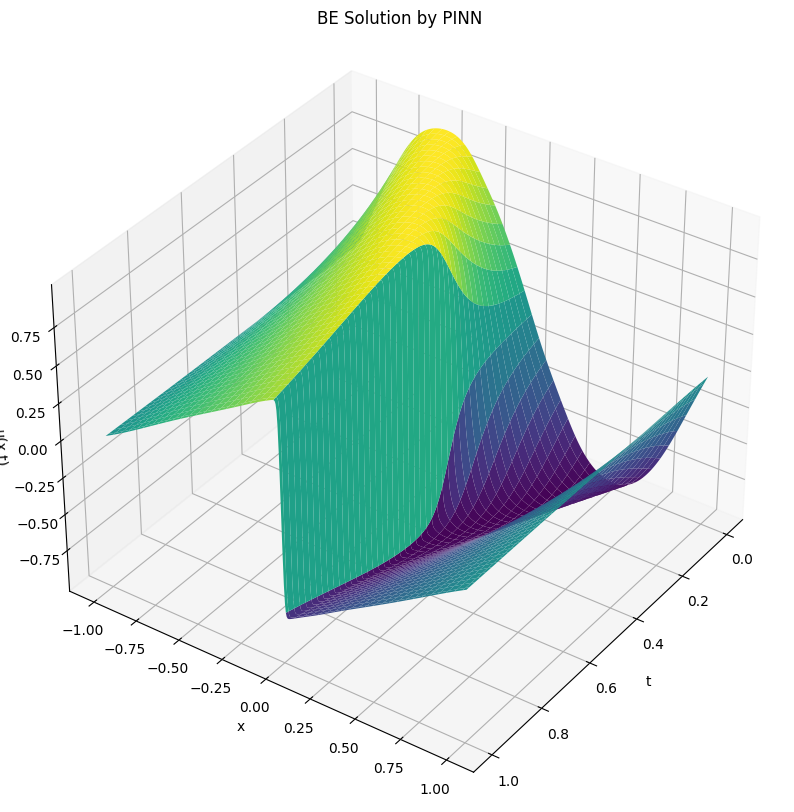

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(35,35)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(x,t)')
ax.set_title('BE Solution by PINN')

This result visibly matches with the figure present in the paper

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses, val_losses = [], []
t0 = time()
for i in range(1,N+1):
  loss, val_loss = train_step_with_val()
  losses.append(loss.numpy())
  val_losses.append(val_loss.numpy())
print('Final Training Loss = '+str(losses[-1])+' and Final Validation Loss = '+str(val_losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0)) # CPU

Final Training Loss = 0.0005885837 and Final Validation Loss = 0.00064519234
Computation Time = 281.5114018917084 seconds
